# Вариационный вывод

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import norm,gamma,dirichlet
%matplotlib inline

from IPython.display import Image

### Задача 1. Одномерная гауссиана 
Для начала давайте посмотрим на пример работы вариационного вывода на простом примере, где вариационный вывод и не нужен на самом-то деле.

Рассмотрим задачу восстановления параметров одномерного нормального распределения по данным. Нам дана выборка $x_1,...,x_N$ из нормального распределения $\mathcal{N}(x|\mu,\lambda)$ с неизвестными параметрами. 

In [2]:
k = 1
mu = 20*(np.random.rand(k)-0.5)
std = 2*np.random.rand(k)+0.5
pi = np.random.rand(k)
pi = pi/pi.sum()

In [3]:
n = 100
z = np.random.choice(np.arange(k),p=pi,size=n)
x = np.random.normal(loc = mu[z],scale=std[z])

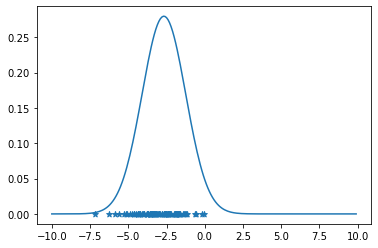

In [4]:
x_plot = np.arange(-10,10,0.1)
for i in range(k):
    plt.plot(x_plot,norm.pdf(x_plot,loc=mu[i],scale=std[i])*pi[i])
    plt.scatter(x[z==i],np.zeros((z==i).sum()),marker = '*',)

#### Вероятностная модель
В качестве априорного распределени на $\mu,\lambda$ возьмем нормал-гамма распеделение, так как оно сопряжено нормальному правдоподобию. Вероятностная модель нашей задачи выглядит следующим образом:

$$p(x,\mu,\lambda|m_0,\beta_0,a_0,b_0) = \left[\prod_n \mathcal{N}(x_n|\mu,\lambda^{-1})\right]\mathcal{N}(\mu|m_0,(\beta_0\lambda)^{-1})\mathcal{G}(\lambda | a_0, b_0),$$

где $m_0,\beta_0,a_0,b_0$ -- фиксированные параметры априорных распределений, а нормальное и гамма распределения заданы в следующей параметризации:

$$\mathcal{N}(x \,\mid \mu, \, \lambda^{-1})=\sqrt{\frac{\lambda}{2 \pi}} e^{-\frac{\lambda}{2}(x-\mu)^{2}},\quad \mathcal{G}(\lambda\mid a,b) = \frac{b^a}{\Gamma(a)}\lambda^{a-1}\exp(-b\lambda).$$


#### Полный байесовский вывод
В этой модели все сопряжено, поэтому можно сделать полный байесовский вывод. В этом случае апостериорное распределение на $\mu,\lambda$ будет нормал-гамма с новыми параметрами:

$$\begin{aligned}
p(\mu,\lambda|x) &\propto \left[\prod_n \mathcal{N}(x_n|\mu,\lambda^{-1})\right]
\mathcal{N}(\mu|m_0,(\beta_0\lambda)^{-1})\mathcal{G}(\lambda | a_0, b_0)\propto\\
&\propto\left[\prod_n \sqrt{\lambda}\exp\left(-\frac{\lambda}{2}(x_n-\mu)^2\right)\right]
\sqrt{\beta_0\lambda}\exp\left(\frac{\beta_0\lambda}{2}(\mu-m_0)^2\right)\lambda^{a_0-1}\exp(-b_0\lambda)\propto\\
&\propto\lambda^{a_0-1+\frac{N+1}{2}}\exp\left(\frac{\mu^2\lambda}{2}(\beta_0+N)+\mu\lambda(\beta_0m_0+\sum_nx_n)-b_0\lambda-\frac{\lambda}{2}(\beta_0m_0^2+\sum_nx_n^2)\right)\propto\\
&\propto\sqrt{\lambda}\exp\left(\frac{\mu^2\lambda}{2}(\beta_0+N)+\mu\lambda(\beta_0+N)\frac{\beta_0m_0+\sum_nx_n}{\beta_0+N}-\frac{\lambda}{2}(\beta_0+N)(\frac{\beta_0m_0+\sum_n x_n}{\beta_0+N})^2\right)\cdot \\
&\cdot \lambda^{a_0-1+\frac{N}{2}}\exp\left(-\lambda\left[b_0+\frac{1}{2}(\beta_0m_0^2+\sum_nx_n^2-(\beta_0+N)(\frac{\beta_0m_0+\sum_n x_n}{\beta_0+N})^2)\right]\right)
\end{aligned}$$

Итого получили, что апостериорное распределение:
$$p(\mu,\lambda|x) = \mathcal{N}(\mu|m,(\beta\lambda)^{-1})\mathcal{G}(\lambda|a,b),$$
$$m = \frac{\beta_0m_0+\sum_n x_n}{\beta_0+N},\quad \beta = \beta_0+N,\quad a=a_0+\frac{N}{2},\quad b=b_0+\frac{1}{2}\left(\beta_0m_0^2+\sum_nx_n^2-\beta m^2\right).$$

#### Вариационный вывод

А можно применить mean-field variational inference и приблизить апотериорное распределение в факторизованном семействе:

$$p(\mu,\lambda|x)\approx q(\mu)q(\lambda).$$

В этом случае на $\mu$ мы получим номральное распределение, а на $\lambda$ -- гамма распределение. 

Вывод для $\mu$:

$$\begin{aligned}
\log q(\mu) &\propto \mathbb{E}_{q(\lambda)}\log p(x,\mu,\lambda) \propto\mathbb{E}_{q(\lambda)}\left[\sum_n \log\mathcal{N}(x_n|\mu,\lambda^{-1})+\log\mathcal{N}(\mu|m_0,(\beta_0\lambda)^{-1})\right]\propto\\
&\propto \mathbb{E}_{q(\lambda)}\left[-\sum_n \frac{\lambda}{2}(x_n-\mu)^2-\frac{\beta_0\lambda}{2}(\mu-m_0)^2\right]\propto\left[-\frac{\mathbb{E}_{q(\lambda)}\lambda}{2}\sum_n(x_n-\mu)^2-\frac{\beta_0\mathbb{E}_{q(\lambda)}\lambda}{2}(\mu-m_0)^2\right]\propto \\
&\propto -\mu^2\frac{(N+\beta_0)\mathbb{E}_{q(\lambda)}\lambda}{2}+\mu\mathbb{E}_{q(\lambda)}\lambda(\sum_nx_n+m_0\beta_0)
\end{aligned}$$

В итоге:
$$q(\mu) = \mathcal{N}(\mu|m,\beta^{-1}),\quad m = \frac{\sum_nx_n+m_0\beta_0}{\beta_0+N},\quad \beta = (N+\beta_0)\mathbb{E}_{q(\lambda)}\lambda.$$

Вывод для $\lambda$:

$$\begin{aligned}
\log q(\lambda) &\propto \mathbb{E}_{q(\mu)}\log p(x,\mu,\lambda) \propto\mathbb{E}_{q(\mu)}\left[\sum_n \log\mathcal{N}(x_n|\mu,\lambda^{-1})+\log\mathcal{N}(\mu|m_0,(\beta_0\lambda)^{-1})+\log\mathcal{G}(\lambda | a_0, b_0)\right]\propto\\
&\propto \mathbb{E}_{q(\mu)}\left[\sum_n\left(\frac{1}{2}\log\lambda-\frac{\lambda}{2}(x_n-\mu)^2\right)+\frac{1}{2}\log\lambda-\frac{\beta_0\lambda}{2}(\mu-m_0)^2+(a_0-1)\log\lambda-b_0\lambda\right]\propto \\
&\propto \log\lambda\left(\frac{N+1}{2}+a_0-1\right)-\lambda\left(\frac{1}{2}\sum_n\mathbb{E}_{q(\mu)}(x_n-\mu)^2+\frac{\beta_0}{2}\mathbb{E}_{q(\mu)}(\mu-m_0)^2+b_0\right)
\end{aligned}$$

В итоге:
$$q(\lambda) = \mathcal{G}(\lambda|a,b),\quad a = \frac{N+1}{2}+a_0,\quad b = \frac{1}{2}\sum_n\mathbb{E}_{q(\mu)}(x_n-\mu)^2+\frac{\beta_0}{2}\mathbb{E}_{q(\mu)}(\mu-m_0)^2+b_0.$$

Математические ожидания достаточных статистик $\mathbb{E}_{q(\mu)}\mu,\mathbb{E}_{q(\mu)}\mu^2,\mathbb{E}_{q(\lambda)}\lambda$, необходимые в формулах выше, можно взять напрямую или через метод дифференцирования логарифма нормировочной константы (см. википедию Exponential family).

Посмотрим для начала чем отличаются нормал-гамма распределение $\mathcal{NG}(\mu,\lambda)$ и произведение нормального на гамму $\mathcal{N}(\mu)\mathcal{G}(\lambda)$ при каких-то произвольных параметрах.

In [5]:
def normal_gamma_pdf(mu,lam,m,beta,a,b):
    return (norm.pdf(mu,loc = m, scale = 1/(beta*lam)**2)*gamma.pdf(lam,a,scale = 1/b))

def normal_times_gamma_pdf(mu,lam,m,beta,a,b):
    return (norm.pdf(mu,loc = m, scale = 1/(beta)**2)*gamma.pdf(lam,a,scale = 1/b))

<ipython-input-5-6d808ea60322>:2: RuntimeWarning: divide by zero encountered in true_divide
  return (norm.pdf(mu,loc = m, scale = 1/(beta*lam)**2)*gamma.pdf(lam,a,scale = 1/b))


Text(0.5, 1.0, 'Normal times Gamma')

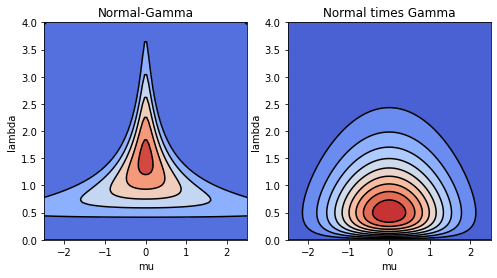

In [6]:
fig, axs = plt.subplots(1, 2,figsize=(8,4))

m,beta,a,b = 0,1,2,2
xmin, xmax, ymin, ymax = -2.5,2.5,0,4
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

f = np.array([normal_gamma_pdf(xx[i],yy[i],m,beta,a,b) for i in range(len(xx))])
axs[0].set_xlim(xmin, xmax)
axs[0].set_ylim(ymin, ymax)
axs[0].contourf(xx, yy, f, cmap='coolwarm',levels=5)
axs[0].contour(xx, yy, f, colors='k',levels=5)
axs[0].set_xlabel('mu')
axs[0].set_ylabel('lambda')
axs[0].set_title('Normal-Gamma')

f = np.array([normal_times_gamma_pdf(xx[i],yy[i],m,beta,a,b) for i in range(len(xx))])
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)
axs[1].contourf(xx, yy, f, cmap='coolwarm',levels=10)
axs[1].contour(xx, yy, f, colors='k',levels=10)
axs[1].set_xlabel('mu')
axs[1].set_ylabel('lambda')
axs[1].set_title('Normal times Gamma')

Видим, что форма значительно различна. Причина в том, что в случае нормал-гамма распределения случайные величины $\mu,\lambda$ являются зависимыми, в отличие от варианта с произведением номрал и гаммы. Из этого, например, следует, что условные распределения $p(\lambda|\mu)$ при разных значениях $\mu$ будут различными в первом случае и одинаковыми во втором.

<ipython-input-5-6d808ea60322>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (norm.pdf(mu,loc = m, scale = 1/(beta*lam)**2)*gamma.pdf(lam,a,scale = 1/b))
<ipython-input-5-6d808ea60322>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (norm.pdf(mu,loc = m, scale = 1/(beta*lam)**2)*gamma.pdf(lam,a,scale = 1/b))
<ipython-input-5-6d808ea60322>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (norm.pdf(mu,loc = m, scale = 1/(beta*lam)**2)*gamma.pdf(lam,a,scale = 1/b))


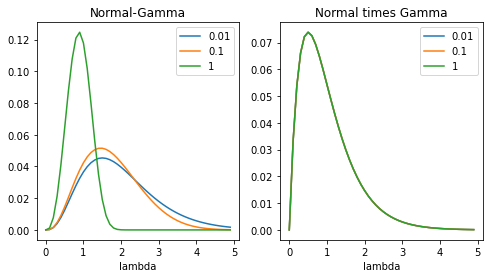

In [7]:
fig, axs = plt.subplots(1, 2,figsize=(8,4))
x_plot = np.arange(0,5,0.1)

for mu in [0.01,0.1,1]:
    y_plot = np.array([normal_gamma_pdf(mu,x_plot[i],m,beta,a,b) for i in range(len(x_plot))])
    y_plot = y_plot/y_plot.sum()
    axs[0].plot(x_plot,y_plot,label=mu)
axs[0].set_xlabel('lambda')
axs[0].set_title('Normal-Gamma')
axs[0].legend()
    
for mu in [0.01,0.1,1]:
    y_plot = np.array([normal_times_gamma_pdf(mu,x_plot[i],m,beta,a,b) for i in range(len(x_plot))])
    y_plot = y_plot/y_plot.sum()
    axs[1].plot(x_plot,y_plot,label=mu)
axs[1].set_xlabel('lambda')
axs[1].set_title('Normal times Gamma')
axs[1].legend()

Вернемся к задаче оценке парамтеров номрального распределения. Ниже мы делаем полный байесовский вывод и вариационный вывод и сравниваем результаты.

In [8]:
def full_bayes_normal_gamma(x, m0, beta0, a0, b0):
    n = len(x)
    beta = beta0+n
    m = (x.sum()+beta0*m0) / (beta0+n)
    a = a0 + n/2
    b = b0 + 0.5*((x*x).sum() + beta0*m0*m0 - (n+beta0)*m*m)
    return (m, beta, a, b)
    
def var_inf_normal_times_gamma(x, m0, beta0, a0, b0):
    n = len(x)
    a, b, m, beta = [],[],[],[]
    a.append(a0)
    b.append(b0)
    m.append(m0)
    beta.append(beta0)
    for iter in range(10):
        # q(mu)
        m.append((x.sum()+beta0*m0) / (beta0+n))
        beta.append((n+beta0)*a[-1]/b[-1])
        # q(lambda)
        a.append(a0 + (n+1)/2.)
        b.append(b0 + (x**2-2*x*m[-1]+m[-1]**2+1/beta[-1]).sum()/2 + beta0/2*(m[-1]**2+1/beta[-1]-2*m[-1]*m0+m0**2))
    return (m, beta, a, b)

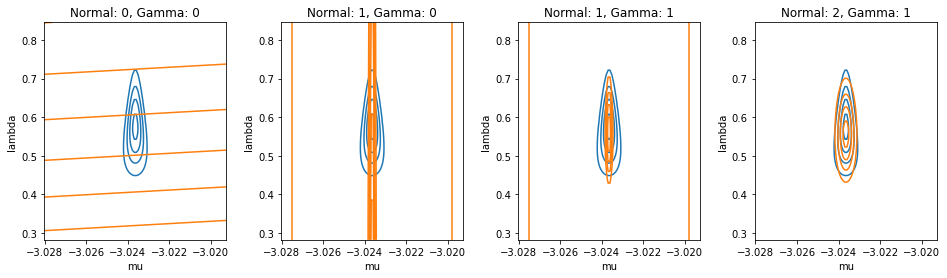

In [9]:
m0, beta0, a0, b0 = 0,1,1,1
m_true,beta_true,a_true,b_true = full_bayes_normal_gamma(x, m0, beta0, a0, b0)
xmin, xmax = m_true-1/4/beta_true/a_true*b_true, m_true+1/4/beta_true/a_true*b_true
ymin, ymax = 0.5*a_true/b_true, 1.5*a_true/b_true
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
f_true = np.array([normal_gamma_pdf(xx[i],yy[i],m_true,beta_true,a_true,b_true) for i in range(len(xx))])

m,beta,a,b = var_inf_normal_times_gamma(x, m0, beta0, a0, b0)

im_num = 4
fig, axs = plt.subplots(1, im_num,figsize=(4*im_num,4))
normal_ind,gamma_ind = 0,0
for im in range(im_num):
    axs[im].set_xlim(xmin, xmax)
    axs[im].set_ylim(ymin, ymax)
    axs[im].contour(xx, yy, f_true, colors='C0',levels=5)
    f = np.array([normal_times_gamma_pdf(xx[i],yy[i],
                                         m[normal_ind],beta[normal_ind],a[gamma_ind],b[gamma_ind]) 
                  for i in range(len(xx))])
    axs[im].contour(xx, yy, f, colors='C1',levels=5)
    axs[im].set_xlabel('mu')
    axs[im].set_ylabel('lambda')
    axs[im].set_title('Normal: {}, Gamma: {}'.format(normal_ind,gamma_ind))
    if im%2:
        gamma_ind += 1
    else:
        normal_ind += 1
    
plt.subplots_adjust(wspace=0.3,hspace=0.3)
    

Выше синим изображены линии уровня честного апостериорного нормал-гамма распределения, полученного при помощи полного байесовского вывода. Оранжевым изображены линии вариационного приближения на разных итерациях вариационного вывода (в подписях к картинкам указано сколько обновлений по параметрам какого распределения сделано).

Видим, что вариационное приближение не идеально. Причины понятны: нельзя факторизованным распределением идеально приблизить распределение, в котором величины зависимы. При этом вариационный вывод достаточно быстро сходится к похожему решению. 

Стоит еще не забывать следующие моменты при использовании вариационного вывода:
- он склонен недооценивать дисперсии приближаемого распределения из-за особенностей обратной KL-дивергенции,
- он выдает смещенную оценку распределения, у которой, например, могут сильно отличаться моменты от реального распределения.